In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import colors

import geopandas as gpd
import numpy as np

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman"],
    "font.size": 14,
    "pdf.fonttype": 42
})

In [3]:
cultural = gpd.read_file("/workspace/Annau2023/data/shapefiles/ne_10m_admin_0_countries.shp")
cultural = cultural[((cultural.ADMIN == "Bahamas") | (cultural.ADMIN == "Canada") | (cultural.ADMIN == "United States of America") | (cultural.ADMIN == "Cuba") | (cultural.ADMIN == "Mexico"))].boundary
lakes = gpd.read_file("/workspace/Annau2023/data/shapefiles/ne_10m_lakes.shp")
lakes = lakes[lakes.scalerank <= 2].boundary
world = cultural.geometry.append(lakes.geometry)

In [4]:
u10 = xr.open_dataset("/workspace/Annau2023/data/full_domain/regrid_16_6hrly_wrf2d_d01_ctrl_U10_200209.nc").U10
v10 = xr.open_dataset("/workspace/Annau2023/data/full_domain/regrid_16_6hrly_wrf2d_d01_ctrl_V10_200209.nc").V10

i = 110
field = xr.apply_ufunc(np.hypot, u10[i, ...].load(), v10[i, ...].load())

cmap = "viridis"

inset_area = {
    "Continental": (slice(8*9, 8*47), slice(8*29, 8*67)),
    "Southeast": (slice(8*4, 8*20), slice(8*70, 8*86)),
    "Central": (slice(8*30, 8*46), slice(8*50, 8*66)),
    "West": (slice(8*30, 8*46), slice(8*15, 8*31))
}


In [5]:
def add_patch(ax, extent, zorder):
    rect = patches.Rectangle(
        (extent[0], extent[2]),
        extent[1]-extent[0],
        extent[3]-extent[2],
        linewidth=1.5,
        edgecolor='white',
        facecolor='none',
        zorder=zorder,
    )
    ax.add_patch(rect)

def add_region_text(ax, extent, text, zorder):
    ax.text(
        extent[0] + (extent[1]-extent[0])/2,
        extent[2]+0.5, text, fontsize=15,
        color="white",
        ha='center',
        va='center',
        zorder=zorder
    )

def get_extent(field):
    return [field.lon.min(),field.lon.max(), field.lat.min(), field.lat.max()]

This is a somewhat cumbersome way of plotting this, but there are lots of features to the plot that I added from trial and error. 

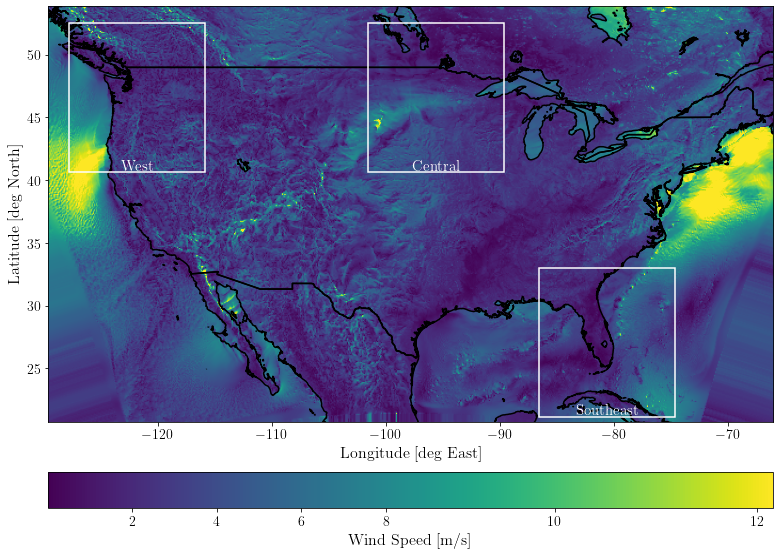

In [8]:
fig, ax = plt.subplots(figsize=[13, 15.5])

plotrange = slice(28, -50), slice(100, -100)
field_to_plot = xr.apply_ufunc(
    np.hypot,
    u10[i, plotrange[0],
    plotrange[1]].load(),
    v10[i, plotrange[0], plotrange[1]].load()
)

xl1, xl2, yl1, yl2 = get_extent(field_to_plot)

vmin, vmax = field.min().compute(), field.max().compute()
divnorm=colors.TwoSlopeNorm(vmin=vmin, vcenter=(vmax+vmin)/2, vmax=vmax-5)

full_extent = get_extent(field)
full_extent_to_plot = get_extent(field_to_plot)
continental_extend = inset_area["Continental"]
central_extend = inset_area["Central"]
west_extend = inset_area["West"]
florida_extend = inset_area["Southeast"]

continental_field = field[continental_extend[0], continental_extend[1]]
central_field = field[central_extend[0], central_extend[1]]
west_field = field[west_extend[0], west_extend[1]]
florida_field = field[florida_extend[0], florida_extend[1]]


central_phys_extent = get_extent(central_field)
west_phys_extent = get_extent(west_field)
florida_phys_extent = get_extent(florida_field)


col = ax.imshow(field_to_plot, origin="lower", extent=full_extent_to_plot, cmap=cmap, norm=divnorm)
ax.set_xlim(xl1, xl2)
ax.set_ylim(yl1, yl2)

ax.set_xlabel("Longitude [deg East]", fontsize=16)
ax.set_ylabel("Latitude [deg North]", fontsize=16)
cbar = plt.colorbar(col, orientation="horizontal", pad=0.06)
cbar.ax.set_xlabel('Wind Speed [m/s]', fontsize=16)

add_patch(ax, florida_phys_extent, 5)
add_patch(ax, west_phys_extent, 6)
add_patch(ax, central_phys_extent, 7)

add_region_text(ax, florida_phys_extent, "Southeast", 5)
add_region_text(ax, central_phys_extent, "Central", 6)
add_region_text(ax, west_phys_extent, "West", 7)

world.plot(ax=ax, color="black")

plt.savefig(
    "/workspace/paper/pdfs/fig1.pdf",
    bbox_inches='tight',
    format='pdf',
    dpi=350
)